<b><span style="color:green; font-size:150%">Micro-Business Density forecast:
with focus on feature engineering of census data and time-series based data [simple version]</span></b>


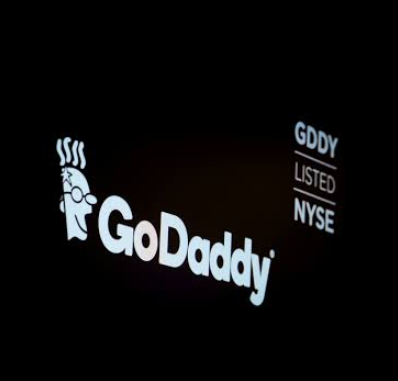

# **<span style="color:#F7B2B0;">Problem Statment & workflow summary</span>**
In this competition we are given 3,135 (the unique number of county) time-series of length 39 (time span). With those data, we should predict We must predict microbusiness density for the 8 months November 2022 thru June 2023. 

This is not a easy task. **Time span is too short** for making a prediction. As there are **only 39 data points for each county**, our ML model couldn't learn a lot from historical data. 

The workflow would be like this flowchart:
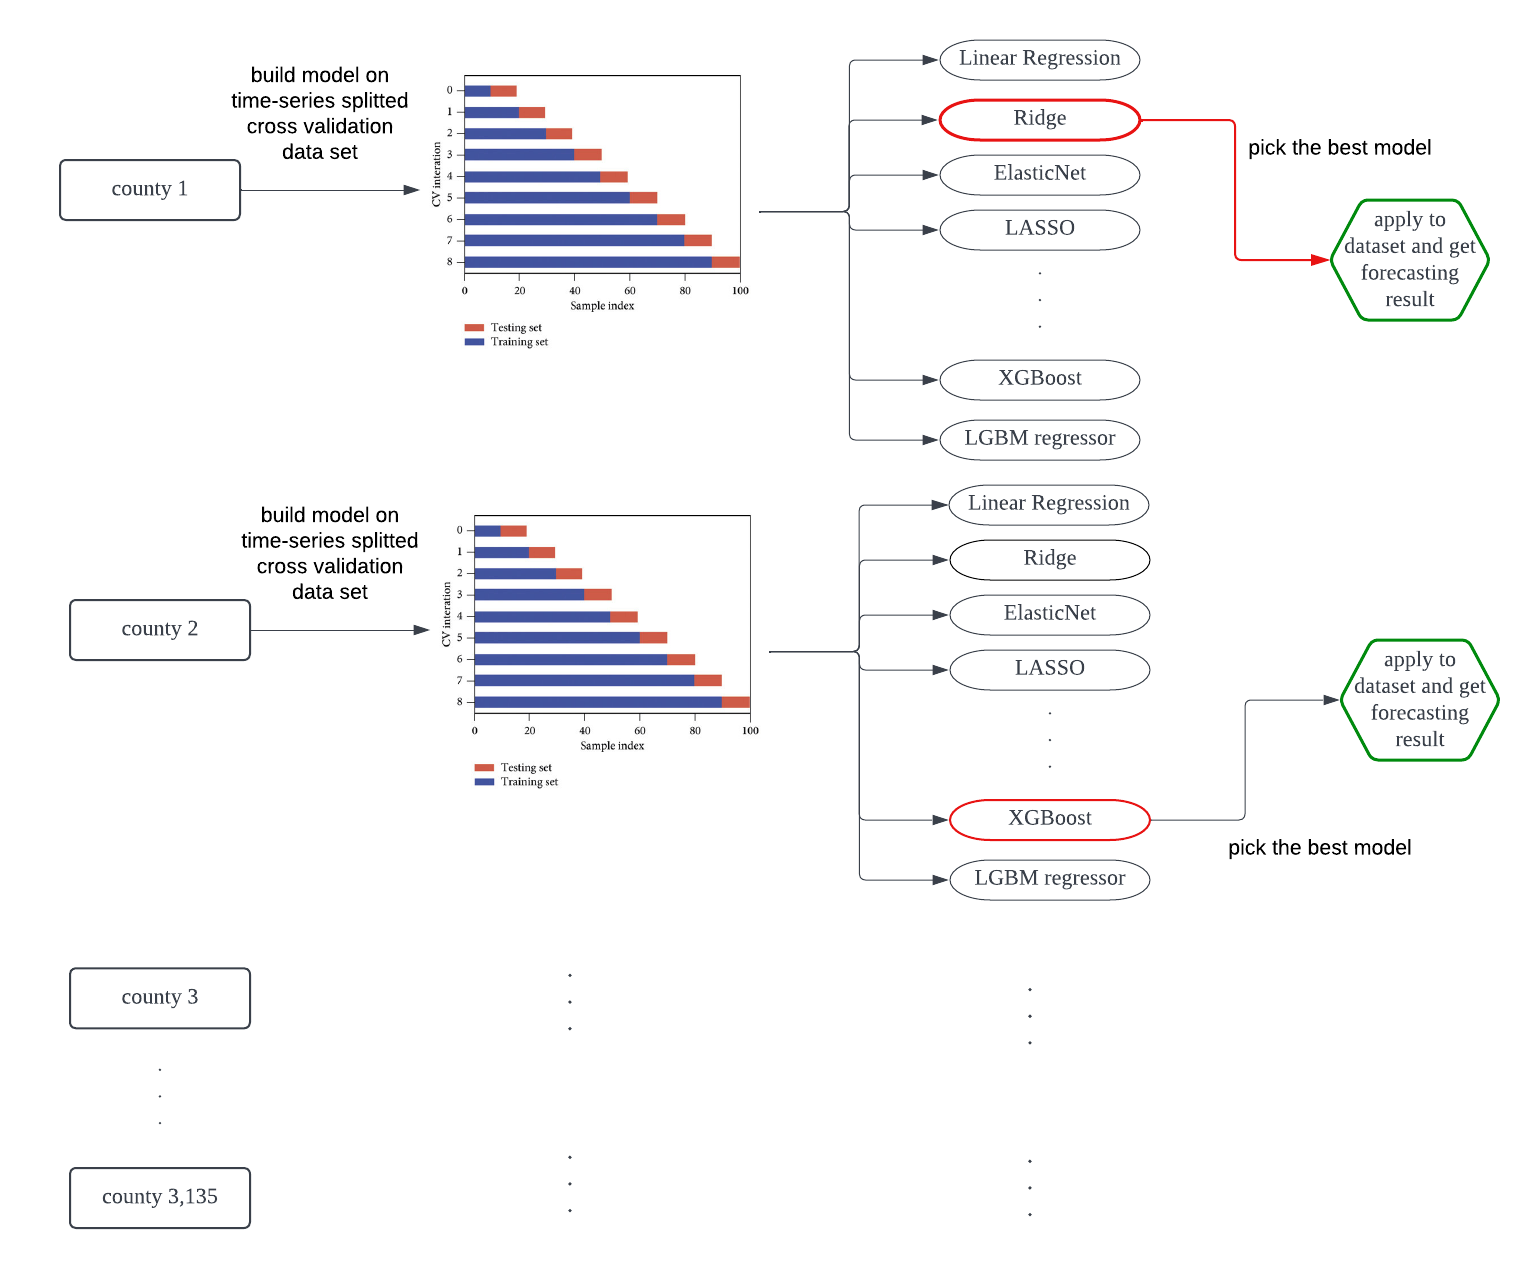



### It means we train 3,135 * (the number of different models you will train) !!!


# **<span style="color:#F7B2B0;">feature engineering overview</span>**

Even though this is a tough task, we should find the best model. I think the key is 'feature engineering'. What kind of variables can we add to this model? 
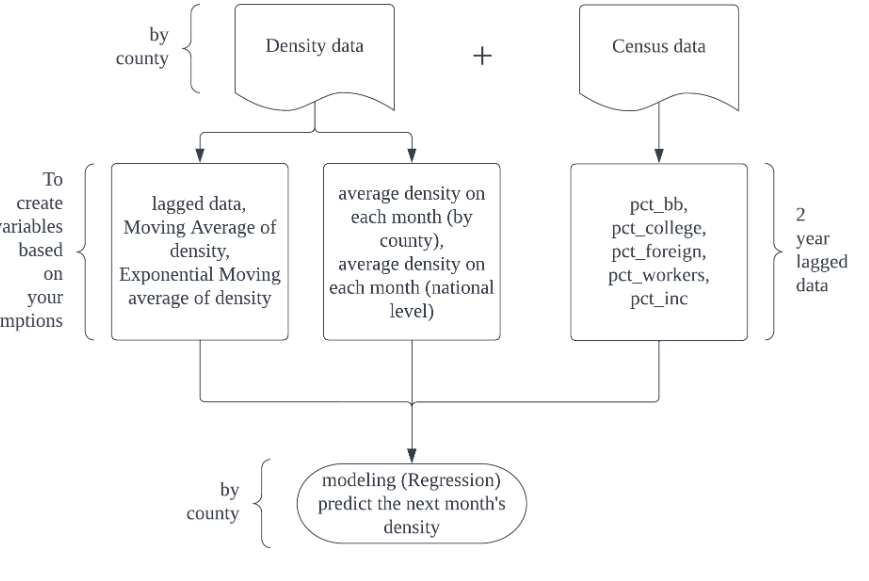


As we have time-series data, we can make **time-series based variables**. 
1) lag data : The lag time is the time between the two time series you are correlating. It is reasonable to think that yesterday's stock price would affect today's stock price. :)

2) moving average : The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 2days, 3days, a week etc...


3) weighted moving average / Exponetioanl moving Average: Exponential Moving Average (EMA) is similar to Simple Moving Average (SMA), measuring trend direction over a period of time. However, whereas SMA simply calculates an average of price data, EMA applies more weight to data that is more current.


Also, the census data is given. As it noted,all fields have a two year lag to match what information was avaiable at the time a given microbusiness data update was published.

- pct_bb_[year] - The percentage of households in the county with access to broadband of any type. 
- pct_college_[year] - The percent of the population in the county over age 25 with a 4-year college degree.
- pct_foreign_born_[year] - The percent of the population in the county born outside of the United States. 
- pct_it_workers_[year] - The percent of the workforce in the county employed in information related industries.
- median_hh_inc_[year] - The median household income in the county.

As it is reasonble that these factors could affect the number of micro-business and the number of young people in each county, I will include those variables. 

Finally,we should consider **'national-wide' and 'state-wide' factors**, like average micro-business density in each state on each month or national average micro-business density each month. Therefore, I will also create these variables and try to use it for prediction.


### 🗨️ if you want to check more on EDA precess, please visit below notetook:
https://www.kaggle.com/code/kimtaehun/complete-baseline-code-with-various-ml-model

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', 500)

import plotly.figure_factory as ff
import geopandas
import shapely
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import TimeSeriesSplit

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
# create function for MA and EWM
#SMA and EMA are both commonly-used trend indicators. SMA gives equal weight to all data points,  while EMA applies more weight to recent data points. 

def moving_average(df,i, n):
    MA = pd.Series(df[i].rolling(n, min_periods=n).mean(), name = 'MA_' + str(n))
    df = df.join(MA)
    return df

def weighted_moving_average(df,i, n):
    EMA = pd.Series(df[i].ewm(span=n, adjust=False, min_periods=n).mean(), name = 'EMA_' + str(n))
    df = df.join(EMA)
    return df

In [3]:
# load dataset

df_train = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
df_test = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')
df_census = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv')

In [4]:
# combine train and testset
df_train['dataset'] = 'train'
df_test['dataset'] = 'test'
df = pd.concat((df_train, df_test)).sort_values('row_id').reset_index(drop=True)

In [5]:
# merge census data with train-test dataset. 
df_all = df.merge(df_census, on = 'cfips', how='left')

In [6]:
df_all['first_day_of_month'] = pd.to_datetime(df_all["first_day_of_month"])
df_all["year"] = df_all["first_day_of_month"].dt.year
df_all['month'] = df_all["first_day_of_month"].dt.month

In [7]:
# add 2-year lag census data to each rows 

conditions = [df_all['year']==2019,df_all['year']==2020,df_all['year']==2021, df_all['year']==2022, df_all['year']==2023]
choices_bb = [df_all['pct_bb_2017'],df_all['pct_bb_2018'],df_all['pct_bb_2019'],df_all['pct_bb_2020'],df_all['pct_bb_2021'] ]
choices_college = [df_all['pct_college_2017'],df_all['pct_college_2018'],df_all['pct_college_2019'],
                   df_all['pct_college_2020'],df_all['pct_college_2021']]
choices_foreign = [df_all['pct_foreign_born_2017'],df_all['pct_foreign_born_2018'],df_all['pct_foreign_born_2019'],
                   df_all['pct_foreign_born_2020'],df_all['pct_foreign_born_2021']]
choices_workers = [df_all['pct_it_workers_2017'],df_all['pct_it_workers_2018'],df_all['pct_it_workers_2019'],
                   df_all['pct_it_workers_2020'],df_all['pct_it_workers_2021']]
choices_inc = [df_all['median_hh_inc_2017'],df_all['median_hh_inc_2018'],df_all['median_hh_inc_2019'],
               df_all['median_hh_inc_2020'],df_all['median_hh_inc_2021']]

In [8]:
df_all["pct_bb"] = np.select(conditions, choices_bb, default=np.nan)
df_all["pct_college"] = np.select(conditions, choices_college, default=np.nan)
df_all["pct_foreign"] = np.select(conditions, choices_foreign, default=np.nan)
df_all["pct_workers"] = np.select(conditions, choices_workers, default=np.nan)
df_all["pct_inc"] = np.select(conditions, choices_inc, default=np.nan)

In [9]:
# drop unnecessary columns
df_all.drop(['pct_bb_2017', 'pct_bb_2018',
       'pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021', 'pct_college_2017',
       'pct_college_2018', 'pct_college_2019', 'pct_college_2020',
       'pct_college_2021', 'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021'], axis=1, inplace=True)

In [10]:
# using pivot table to check the trend of micro-biz
train_pivoted = df_all.pivot(index='cfips',columns='first_day_of_month',values='microbusiness_density')

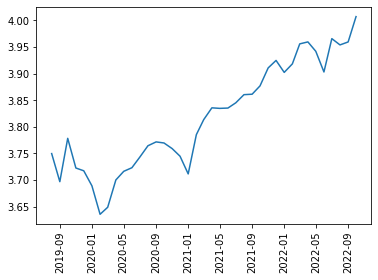

In [11]:
# micro-business density 

plt.plot(train_pivoted.mean(axis=0));
plt.xticks(rotation=90);

Microbusinesses per 100 people over the age of 18 in the given county. This is the target variable. The population figures used to calculate the density are on a two-year lag due to the pace of update provided by the U.S. Census Bureau, which provides the underlying population data annually.

It seems like micro-business was affected by Covid-19 (where it dropped dramatically). However, 4 out of 100 people over the age of 18 in the given county running their own business Now.

In [12]:
# generate time-series based variables.
# create Moving Average variable.
df_all = moving_average(df_all, 'microbusiness_density', 3)
df_all = moving_average(df_all, 'microbusiness_density', 6)

# actually it's Exponential Moving Average. 
df_all = weighted_moving_average(df_all, 'microbusiness_density', 3)
df_all = weighted_moving_average(df_all, 'microbusiness_density', 6)

#### please note that you can add any MA or EMA that you think reasonable, like 5days, 10days...

In [13]:
# add 'pct_change_before' variable. This variable shows that how the density changed previous month.
df_all['pct_change_before'] = df_all['microbusiness_density'].pct_change().shift(1)

In [14]:
# gnerate lag date


def lag_feature(df):
    for lag in range(1, 6):
        df[f'lag_density_{lag}'] = df.groupby('cfips')['microbusiness_density'].shift(lag)
        df[f'lag_density_{lag}'] = df.groupby('cfips')[f'lag_density_{lag}'].bfill()
        
    return df
    
df_all = lag_feature(df_all)

#### As I mentioned, we should consider **'national-wide' and 'state-wide' factors**, like average micro-business density in each state on each month or national average micro-business density each month. 

In [15]:
# the average microbusiness density in each state by month
# each month's national average microbusines_density 
df_all['national_avg'] = df_all.groupby(['year','month'])['microbusiness_density'].transform('mean')
df_all['state_avg'] = df_all.groupby(['state','year','month'])['microbusiness_density'].transform('mean')

### create target variable
Now, we need to create target column. 
As we are trying to predict the next month's micro-biz density,
we should shift the 'microbusiness_density' variables like below.

In [16]:
df_all['target'] = df_all.groupby('cfips')['microbusiness_density'].shift(-1)

In [17]:
# check columns
df_all.columns

Index(['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density', 'active', 'dataset', 'year', 'month', 'pct_bb',
       'pct_college', 'pct_foreign', 'pct_workers', 'pct_inc', 'MA_3', 'MA_6',
       'EMA_3', 'EMA_6', 'pct_change_before', 'lag_density_1', 'lag_density_2',
       'lag_density_3', 'lag_density_4', 'lag_density_5', 'national_avg',
       'state_avg', 'target'],
      dtype='object')

**Not all columns are need for prediction**. 
Definetely, we should exclude row_id, state etc. 

So the next step is exclude unnecessary columns.

In [18]:
#SMAPE formula : Symmetric mean absolute percentage error
# https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
# SMAPE = (1/n) * Σ(|forecast – actual| / ((|actual| + |forecast|)/2) * 100
'''
advantages: 
Expressed as a percentage.
Fixes the shortcoming of the original MAPE — it has both the lower (0%) and the upper (200%) bounds.

'''
def SMAPE(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [19]:
# replace inf values to NaN, otherwise you will encounter error on the next step.
df_all = df_all.replace([np.inf, -np.inf], np.nan)

In [33]:
# feature_list

feature_list = ['year', 'month', 'pct_bb','microbusiness_density',
       'pct_college', 'pct_foreign', 'pct_workers', 'pct_inc', 'MA_3', 'MA_6',
       'EMA_3', 'EMA_6', 'lag_density_1', 'lag_density_2',
       'lag_density_3', 'lag_density_4', 'lag_density_5', 'pct_change_before',
       'national_avg', 'state_avg']


In [34]:
# separate train dataset
sample_train = df_all[df_all['dataset']=='train']

In [35]:
train_X = sample_train[feature_list]
train_y = sample_train['target']

#### please note that we are going to use timeseires split, so that we could aviod to cheating feature data (data leakage).
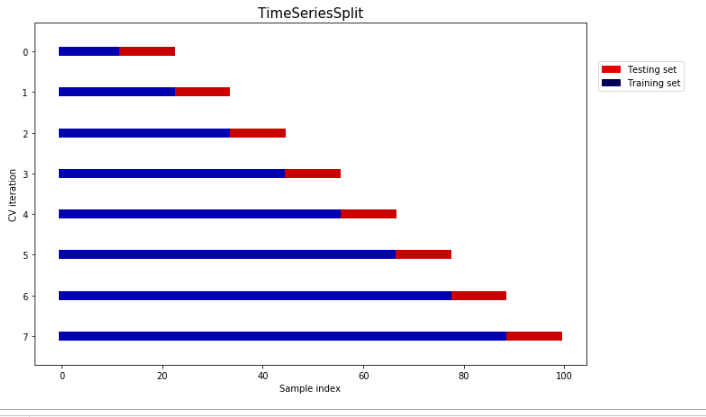

In [36]:
def smape_cv(model):
    tscv = TimeSeriesSplit(n_splits=7)
    smape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), 
                                             desc=f'{model_name} Cross Validations', total=7):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        smape = SMAPE(y_test, pred) 
        smape_list.append(smape)
    return model_name, smape_list

def print_smape_score(model):
    model_name, score = smape_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} smape: {r:.4f}')
    print(f'\n{model_name} mean smape: {np.mean(score):.4f}')
    print('='*30)
    return model_name, np.mean(score)

In [37]:
# Train 8 models for each county !!! Please note that this is just a sample code. You Should modify or tweak below parameters to get better performance.
reg = LinearRegression(n_jobs=-1)
ridge = Ridge(alpha=0.8, random_state=1)
lasso = Lasso(alpha = 0.01, random_state=1)
Enet = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)
DTree = DecisionTreeRegressor(max_depth=5, min_samples_split=2, min_samples_leaf=2, random_state=1)
rf = RandomForestRegressor(n_estimators=500, criterion='mse', max_depth=5, min_samples_split=2,
                           min_samples_leaf=2, random_state=1, n_jobs=-1)
model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=5, min_child_weight=5, gamma=0.1, n_jobs=-1)
model_lgb = lgb.LGBMRegressor(n_estimators=500, max_depth=5, min_child_weight=5, n_jobs=-1)

In [40]:
model_list = [reg, ridge, lasso, Enet, DTree, rf, model_xgb, model_lgb]

<span style = 'color: #008000'> **Due to time contraints, I just test it on the sample list (randomly select 4 counties)** </span>

In [41]:
test_list = [9011, 9007, 40055, 29107]

#to get all the county list, change test_list to df_all.cfips.unique()

In [45]:
submit_df = pd.DataFrame()
model_results = {}
county_and_model = {}

for i in test_list:
    print(f'======================= county {i} modeling =====================')
    sample = df_all[df_all['cfips']==i]
    sample_train = sample[sample['dataset']=='train']
    train_X = sample_train[['year', 'month', 'pct_bb','microbusiness_density',
       'pct_college', 'pct_foreign', 'pct_workers', 'pct_inc', 'MA_3', 'MA_6',
       'EMA_3', 'EMA_6', 'lag_density_1', 'lag_density_2',
       'lag_density_3', 'lag_density_4', 'lag_density_5', 'pct_change_before',
       'national_avg', 'state_avg']]
    train_y = sample_train['target']
    train_X.fillna(method='bfill', inplace=True)
    train_X.fillna(method='ffill', inplace=True)
    
    model_dict = {}
    for model in [reg, ridge, lasso, Enet, DTree, rf, model_xgb, model_lgb]:
        model_name, mean_score = print_smape_score(model)
        model_dict[model_name] = mean_score
        model_results[i] = min(model_dict.values())
        
    final_model = model_list[list(model_dict.keys()).index(min(model_dict, key=model_dict.get))]
    
    sample.fillna(method='ffill', inplace=True)
    
    # select testset
    sample_test = sample[sample['dataset']=='test']
    submit_X = sample_test[['year', 'month', 'pct_bb','microbusiness_density',
       'pct_college', 'pct_foreign', 'pct_workers', 'pct_inc', 'MA_3', 'MA_6',
       'EMA_3', 'EMA_6', 'lag_density_1', 'lag_density_2',
       'lag_density_3', 'lag_density_4', 'lag_density_5', 'pct_change_before',
       'national_avg', 'state_avg']]
    #predict with final_model
    county_and_model[i] = min(model_dict, key=model_dict.get)
    #print(county_and_model)
    
    predict_result = final_model.predict(submit_X).tolist()
    
    df = pd.DataFrame(list(zip(sample_test['row_id'].values.tolist(), predict_result)),
              columns=['row_id','microbusiness_density'])
    submit_df = submit_df.append(df)

======================= county 9011 modeling =====================


LinearRegression Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 161.54it/s]


1 FOLDS: LinearRegression smape: 1.1227
2 FOLDS: LinearRegression smape: 1.6780
3 FOLDS: LinearRegression smape: 0.3082
4 FOLDS: LinearRegression smape: 0.8761
5 FOLDS: LinearRegression smape: 0.5571
6 FOLDS: LinearRegression smape: 1.1855
7 FOLDS: LinearRegression smape: 0.4117

LinearRegression mean smape: 0.8770


Ridge Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 172.64it/s]


1 FOLDS: Ridge smape: 0.3655
2 FOLDS: Ridge smape: 1.6548
3 FOLDS: Ridge smape: 0.4999
4 FOLDS: Ridge smape: 0.3484
5 FOLDS: Ridge smape: 0.4018
6 FOLDS: Ridge smape: 0.7186
7 FOLDS: Ridge smape: 0.2275

Ridge mean smape: 0.6024


Lasso Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 169.12it/s]


1 FOLDS: Lasso smape: 0.4381
2 FOLDS: Lasso smape: 1.5152
3 FOLDS: Lasso smape: 0.3675
4 FOLDS: Lasso smape: 0.2912
5 FOLDS: Lasso smape: 0.3291
6 FOLDS: Lasso smape: 0.6997
7 FOLDS: Lasso smape: 0.2902

Lasso mean smape: 0.5616


ElasticNet Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 174.26it/s]


1 FOLDS: ElasticNet smape: 0.3707
2 FOLDS: ElasticNet smape: 1.6812
3 FOLDS: ElasticNet smape: 0.4642
4 FOLDS: ElasticNet smape: 0.3399
5 FOLDS: ElasticNet smape: 0.3734
6 FOLDS: ElasticNet smape: 0.6976
7 FOLDS: ElasticNet smape: 0.2248

ElasticNet mean smape: 0.5931


DecisionTreeRegressor Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 182.77it/s]


1 FOLDS: DecisionTreeRegressor smape: 2.1602
2 FOLDS: DecisionTreeRegressor smape: 1.1335
3 FOLDS: DecisionTreeRegressor smape: 0.1462
4 FOLDS: DecisionTreeRegressor smape: 1.1588
5 FOLDS: DecisionTreeRegressor smape: 0.5878
6 FOLDS: DecisionTreeRegressor smape: 0.6993
7 FOLDS: DecisionTreeRegressor smape: 1.4688

DecisionTreeRegressor mean smape: 1.0506


RandomForestRegressor Cross Validations: 100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


1 FOLDS: RandomForestRegressor smape: 2.4840
2 FOLDS: RandomForestRegressor smape: 0.8254
3 FOLDS: RandomForestRegressor smape: 0.3003
4 FOLDS: RandomForestRegressor smape: 1.0852
5 FOLDS: RandomForestRegressor smape: 1.0289
6 FOLDS: RandomForestRegressor smape: 0.8176
7 FOLDS: RandomForestRegressor smape: 1.1199

RandomForestRegressor mean smape: 1.0944


XGBRegressor Cross Validations: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


1 FOLDS: XGBRegressor smape: 2.7382
2 FOLDS: XGBRegressor smape: 1.1800
3 FOLDS: XGBRegressor smape: 2.0843
4 FOLDS: XGBRegressor smape: 2.7230
5 FOLDS: XGBRegressor smape: 3.0301
6 FOLDS: XGBRegressor smape: 3.0284
7 FOLDS: XGBRegressor smape: 2.3954

XGBRegressor mean smape: 2.4542


LGBMRegressor Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 56.33it/s]


1 FOLDS: LGBMRegressor smape: 2.7382
2 FOLDS: LGBMRegressor smape: 1.1800
3 FOLDS: LGBMRegressor smape: 2.0843
4 FOLDS: LGBMRegressor smape: 2.7230
5 FOLDS: LGBMRegressor smape: 3.3584
6 FOLDS: LGBMRegressor smape: 3.3670
7 FOLDS: LGBMRegressor smape: 3.2984

LGBMRegressor mean smape: 2.6785
======================= county 9007 modeling =====================


LinearRegression Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 189.82it/s]


1 FOLDS: LinearRegression smape: 0.9151
2 FOLDS: LinearRegression smape: 2.8073
3 FOLDS: LinearRegression smape: 1.0622
4 FOLDS: LinearRegression smape: 0.6102
5 FOLDS: LinearRegression smape: 1.6921
6 FOLDS: LinearRegression smape: 0.9286
7 FOLDS: LinearRegression smape: 0.3666

LinearRegression mean smape: 1.1974


Ridge Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 175.52it/s]


1 FOLDS: Ridge smape: 0.7032
2 FOLDS: Ridge smape: 2.4916
3 FOLDS: Ridge smape: 0.8404
4 FOLDS: Ridge smape: 0.5798
5 FOLDS: Ridge smape: 2.4827
6 FOLDS: Ridge smape: 0.5662
7 FOLDS: Ridge smape: 0.1028

Ridge mean smape: 1.1095


Lasso Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 185.73it/s]


1 FOLDS: Lasso smape: 0.5283
2 FOLDS: Lasso smape: 2.4654
3 FOLDS: Lasso smape: 0.1575
4 FOLDS: Lasso smape: 0.2656
5 FOLDS: Lasso smape: 1.2875
6 FOLDS: Lasso smape: 0.5633
7 FOLDS: Lasso smape: 0.2954

Lasso mean smape: 0.7947


ElasticNet Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 168.35it/s]


1 FOLDS: ElasticNet smape: 0.7037
2 FOLDS: ElasticNet smape: 2.4977
3 FOLDS: ElasticNet smape: 0.9372
4 FOLDS: ElasticNet smape: 0.5952
5 FOLDS: ElasticNet smape: 2.4066
6 FOLDS: ElasticNet smape: 0.5618
7 FOLDS: ElasticNet smape: 0.0994

ElasticNet mean smape: 1.1145


DecisionTreeRegressor Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 185.02it/s]


1 FOLDS: DecisionTreeRegressor smape: 0.3705
2 FOLDS: DecisionTreeRegressor smape: 2.1526
3 FOLDS: DecisionTreeRegressor smape: 1.5402
4 FOLDS: DecisionTreeRegressor smape: 0.3535
5 FOLDS: DecisionTreeRegressor smape: 0.5525
6 FOLDS: DecisionTreeRegressor smape: 0.5633
7 FOLDS: DecisionTreeRegressor smape: 0.4708

DecisionTreeRegressor mean smape: 0.8576


RandomForestRegressor Cross Validations: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


1 FOLDS: RandomForestRegressor smape: 0.3533
2 FOLDS: RandomForestRegressor smape: 2.3536
3 FOLDS: RandomForestRegressor smape: 0.2114
4 FOLDS: RandomForestRegressor smape: 0.6275
5 FOLDS: RandomForestRegressor smape: 0.6005
6 FOLDS: RandomForestRegressor smape: 0.6152
7 FOLDS: RandomForestRegressor smape: 0.0928

RandomForestRegressor mean smape: 0.6935


XGBRegressor Cross Validations: 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


1 FOLDS: XGBRegressor smape: 0.3588
2 FOLDS: XGBRegressor smape: 2.4311
3 FOLDS: XGBRegressor smape: 1.4749
4 FOLDS: XGBRegressor smape: 0.4613
5 FOLDS: XGBRegressor smape: 0.4403
6 FOLDS: XGBRegressor smape: 0.5633
7 FOLDS: XGBRegressor smape: 0.1582

XGBRegressor mean smape: 0.8411


LGBMRegressor Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 59.93it/s]


1 FOLDS: LGBMRegressor smape: 0.3588
2 FOLDS: LGBMRegressor smape: 2.4311
3 FOLDS: LGBMRegressor smape: 1.4749
4 FOLDS: LGBMRegressor smape: 0.7591
5 FOLDS: LGBMRegressor smape: 0.5663
6 FOLDS: LGBMRegressor smape: 0.5633
7 FOLDS: LGBMRegressor smape: 0.2754

LGBMRegressor mean smape: 0.9184
======================= county 40055 modeling =====================


LinearRegression Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 200.72it/s]


1 FOLDS: LinearRegression smape: 3.6461
2 FOLDS: LinearRegression smape: 2.5273
3 FOLDS: LinearRegression smape: 6.2460
4 FOLDS: LinearRegression smape: 6.6833
5 FOLDS: LinearRegression smape: 11.9954
6 FOLDS: LinearRegression smape: 3.2169
7 FOLDS: LinearRegression smape: 1.9193

LinearRegression mean smape: 5.1763


Ridge Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 181.21it/s]


1 FOLDS: Ridge smape: 2.0298
2 FOLDS: Ridge smape: 3.9821
3 FOLDS: Ridge smape: 1.2632
4 FOLDS: Ridge smape: 5.9652
5 FOLDS: Ridge smape: 1.6346
6 FOLDS: Ridge smape: 3.7354
7 FOLDS: Ridge smape: 1.6523

Ridge mean smape: 2.8947


Lasso Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 169.77it/s]


1 FOLDS: Lasso smape: 1.8955
2 FOLDS: Lasso smape: 3.9706
3 FOLDS: Lasso smape: 1.4079
4 FOLDS: Lasso smape: 5.8053
5 FOLDS: Lasso smape: 1.5789
6 FOLDS: Lasso smape: 3.1052
7 FOLDS: Lasso smape: 2.2290

Lasso mean smape: 2.8561


ElasticNet Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 163.45it/s]


1 FOLDS: ElasticNet smape: 2.0295
2 FOLDS: ElasticNet smape: 4.0008
3 FOLDS: ElasticNet smape: 1.2869
4 FOLDS: ElasticNet smape: 6.0418
5 FOLDS: ElasticNet smape: 1.7251
6 FOLDS: ElasticNet smape: 3.6359
7 FOLDS: ElasticNet smape: 2.0233

ElasticNet mean smape: 2.9633


DecisionTreeRegressor Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 175.18it/s]


1 FOLDS: DecisionTreeRegressor smape: 2.7059
2 FOLDS: DecisionTreeRegressor smape: 4.4668
3 FOLDS: DecisionTreeRegressor smape: 3.1699
4 FOLDS: DecisionTreeRegressor smape: 3.8815
5 FOLDS: DecisionTreeRegressor smape: 1.3629
6 FOLDS: DecisionTreeRegressor smape: 3.7983
7 FOLDS: DecisionTreeRegressor smape: 1.4427

DecisionTreeRegressor mean smape: 2.9754


RandomForestRegressor Cross Validations: 100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


1 FOLDS: RandomForestRegressor smape: 1.1689
2 FOLDS: RandomForestRegressor smape: 2.5360
3 FOLDS: RandomForestRegressor smape: 1.5988
4 FOLDS: RandomForestRegressor smape: 3.6371
5 FOLDS: RandomForestRegressor smape: 1.3983
6 FOLDS: RandomForestRegressor smape: 2.2261
7 FOLDS: RandomForestRegressor smape: 0.7675

RandomForestRegressor mean smape: 1.9047


XGBRegressor Cross Validations: 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


1 FOLDS: XGBRegressor smape: 1.7840
2 FOLDS: XGBRegressor smape: 3.0128
3 FOLDS: XGBRegressor smape: 2.4052
4 FOLDS: XGBRegressor smape: 4.2651
5 FOLDS: XGBRegressor smape: 1.3035
6 FOLDS: XGBRegressor smape: 2.3861
7 FOLDS: XGBRegressor smape: 2.3780

XGBRegressor mean smape: 2.5050


LGBMRegressor Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 58.29it/s]


1 FOLDS: LGBMRegressor smape: 1.7840
2 FOLDS: LGBMRegressor smape: 3.0128
3 FOLDS: LGBMRegressor smape: 2.4052
4 FOLDS: LGBMRegressor smape: 4.2651
5 FOLDS: LGBMRegressor smape: 1.3035
6 FOLDS: LGBMRegressor smape: 2.3861
7 FOLDS: LGBMRegressor smape: 2.3780

LGBMRegressor mean smape: 2.5049
======================= county 29107 modeling =====================


LinearRegression Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 193.66it/s]


1 FOLDS: LinearRegression smape: 7.0557
2 FOLDS: LinearRegression smape: 141.2357
3 FOLDS: LinearRegression smape: 4.2576
4 FOLDS: LinearRegression smape: 2.0982
5 FOLDS: LinearRegression smape: 3.4005
6 FOLDS: LinearRegression smape: 1.3387
7 FOLDS: LinearRegression smape: 2.0311

LinearRegression mean smape: 23.0597


Ridge Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 189.50it/s]


1 FOLDS: Ridge smape: 4.7295
2 FOLDS: Ridge smape: 7.2380
3 FOLDS: Ridge smape: 0.5781
4 FOLDS: Ridge smape: 0.6265
5 FOLDS: Ridge smape: 2.7814
6 FOLDS: Ridge smape: 1.0492
7 FOLDS: Ridge smape: 1.3910

Ridge mean smape: 2.6277


Lasso Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 175.11it/s]


1 FOLDS: Lasso smape: 3.9577
2 FOLDS: Lasso smape: 7.0784
3 FOLDS: Lasso smape: 0.6791
4 FOLDS: Lasso smape: 0.2516
5 FOLDS: Lasso smape: 2.9288
6 FOLDS: Lasso smape: 1.6802
7 FOLDS: Lasso smape: 1.8386

Lasso mean smape: 2.6306


ElasticNet Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 174.35it/s]


1 FOLDS: ElasticNet smape: 4.7832
2 FOLDS: ElasticNet smape: 7.2114
3 FOLDS: ElasticNet smape: 0.5197
4 FOLDS: ElasticNet smape: 0.5052
5 FOLDS: ElasticNet smape: 2.5846
6 FOLDS: ElasticNet smape: 1.1637
7 FOLDS: ElasticNet smape: 1.4853

ElasticNet mean smape: 2.6076


DecisionTreeRegressor Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 181.76it/s]


1 FOLDS: DecisionTreeRegressor smape: 2.7593
2 FOLDS: DecisionTreeRegressor smape: 2.7217
3 FOLDS: DecisionTreeRegressor smape: 1.6400
4 FOLDS: DecisionTreeRegressor smape: 0.3978
5 FOLDS: DecisionTreeRegressor smape: 3.1477
6 FOLDS: DecisionTreeRegressor smape: 2.2933
7 FOLDS: DecisionTreeRegressor smape: 0.9152

DecisionTreeRegressor mean smape: 1.9822


RandomForestRegressor Cross Validations: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]


1 FOLDS: RandomForestRegressor smape: 2.2023
2 FOLDS: RandomForestRegressor smape: 3.4640
3 FOLDS: RandomForestRegressor smape: 1.2589
4 FOLDS: RandomForestRegressor smape: 0.6432
5 FOLDS: RandomForestRegressor smape: 2.0903
6 FOLDS: RandomForestRegressor smape: 1.3936
7 FOLDS: RandomForestRegressor smape: 0.6773

RandomForestRegressor mean smape: 1.6756


XGBRegressor Cross Validations: 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


1 FOLDS: XGBRegressor smape: 0.4288
2 FOLDS: XGBRegressor smape: 3.0791
3 FOLDS: XGBRegressor smape: 3.8208
4 FOLDS: XGBRegressor smape: 3.4598
5 FOLDS: XGBRegressor smape: 1.0589
6 FOLDS: XGBRegressor smape: 1.1603
7 FOLDS: XGBRegressor smape: 1.7042

XGBRegressor mean smape: 2.1017


LGBMRegressor Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 49.55it/s]


1 FOLDS: LGBMRegressor smape: 0.4288
2 FOLDS: LGBMRegressor smape: 3.0791
3 FOLDS: LGBMRegressor smape: 3.8209
4 FOLDS: LGBMRegressor smape: 3.4598
5 FOLDS: LGBMRegressor smape: 1.0589
6 FOLDS: LGBMRegressor smape: 1.1603
7 FOLDS: LGBMRegressor smape: 1.7042

LGBMRegressor mean smape: 2.1017


In [47]:
#model results is a dictionary that the key is county number and value is each county's the lowest SMAPE score.
model_results

{9011: 0.5615675058645284,
 9007: 0.693467442788328,
 40055: 1.9046612040384014,
 29107: 1.6756434268296072}

In [48]:
# county_and_model is a dictionary that the key is county number and value is each county's selected ML model.
county_and_model 

{9011: 'Lasso',
 9007: 'RandomForestRegressor',
 40055: 'RandomForestRegressor',
 29107: 'RandomForestRegressor'}

In [46]:
# this is submit file :) !!!
submit_df.head()

,row_id,microbusiness_density
0,9011_2022-11-01,4.718742
1,9011_2022-12-01,4.730496
2,9011_2023-01-01,4.765490
3,9011_2023-02-01,4.777244
4,9011_2023-03-01,4.788997


#### Please note that this code still have a room for improvement. Especially when it comes to hyper-parameter tuning. Due to time constraints, I try to make it as simple as possible.
